# VTON Dataset
a notebook to explore the [VTON](https://drive.google.com/file/d/1DBJY3wPyEDvcSvQjZkX8Kjg6nuRDRIa7/view) dataset in order to prepare a `Dataset` class and `Dataloader` 


In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm.notebook import tqdm
import pandas as pd
from glob import glob as Glob
import json
%matplotlib inline

!which python

/usr/intel/bin/bash: /home/gkoren2/miniconda3/envs/ptvae/lib/libtinfo.so.6: no version information available (required by /usr/intel/bin/bash)
/home/gkoren2/miniconda3/envs/ptvae/bin/python


In [2]:
# option 1 to handle images 
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

# Exploration

In [3]:
# dataset_path = '/home/guy/sd1tb/datasets/cp-vton'   # guyx
dataset_path = '/data/users/gkoren2/datasets/cp-vton' # gpu15
os.listdir(dataset_path)

['007586_1.jpg',
 '011086_1.jpg',
 '007806_1.jpg',
 '001593_1.jpg',
 '017559_1.jpg',
 '005021_1.jpg',
 '005223_1.jpg',
 '006035_1.jpg',
 '001509_1.jpg',
 '019197_1.jpg',
 '012728_1.jpg',
 '015710_1.jpg',
 '003004_1.jpg',
 '001666_1.jpg',
 '013472_1.jpg',
 '013396_1.jpg',
 '002153_1.jpg',
 '003884_1.jpg',
 '002479_1.jpg',
 '008600_1.jpg',
 '004635_1.jpg',
 '000193_1.jpg',
 '014393_1.jpg',
 '011983_1.jpg',
 '013013_1.jpg',
 '010144_1.jpg',
 '019509_1.jpg',
 '012160_1.jpg',
 '010267_1.jpg',
 '007510_1.jpg',
 '002689_1.jpg',
 '017662_1.jpg',
 '014833_1.jpg',
 '014407_1.jpg',
 '017128_1.jpg',
 '010581_1.jpg',
 '010023_1.jpg',
 '016079_1.jpg',
 '017448_1.jpg',
 '006913_1.jpg',
 '006463_1.jpg',
 '000723_1.jpg',
 '000321_1.jpg',
 '009415_1.jpg',
 '015941_1.jpg',
 '006274_1.jpg',
 '016648_1.jpg',
 '005043_1.jpg',
 '012420_1.jpg',
 '016297_1.jpg',
 '006085_1.jpg',
 '000637_1.jpg',
 '008712_1.jpg',
 '017361_1.jpg',
 '001232_1.jpg',
 '004016_1.jpg',
 '004488_1.jpg',
 '012859_1.jpg',
 '016306_1.jpg

### Annotations

There are no annotation for this dataset

### images

In [4]:
img_fn=[i for i in Glob(f'{dataset_path}/*.jpg',recursive=True)]
len(img_fn)

14221

In [5]:
imsz = [Image.open(im).size for im in img_fn]
pd.Series(imsz).value_counts()
# plt.imshow(img)

(192, 256)    14221
dtype: int64

all images have the same size

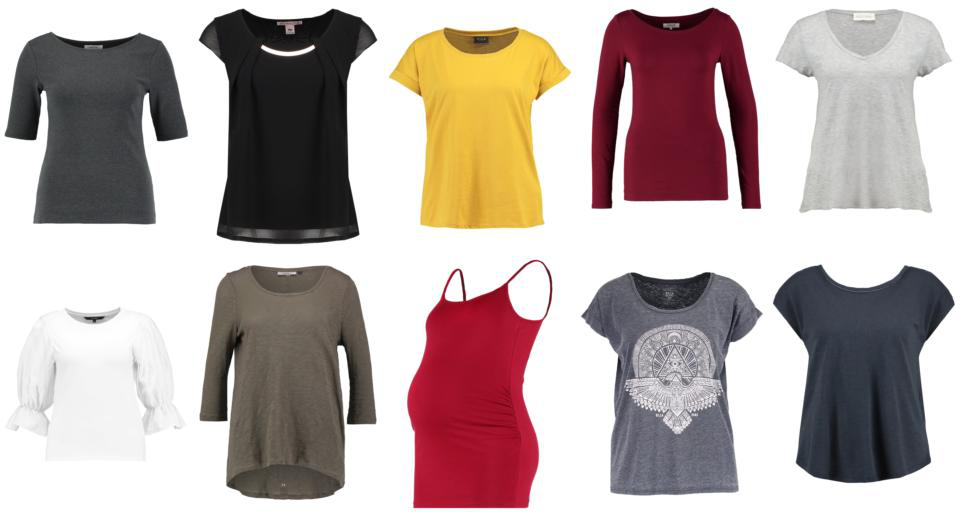

In [6]:
imgs = [Image.open(im) for im in img_fn[:10]]
image_grid(imgs,2,5)

In [ ]:
# resize the images with a limit on each axis size, while maintaining aspect ratio
size=(256,256)
imgs = [Image.open(im) for im in img_fn]
[i.thumbnail(size) for i in imgs]
[im.size for im in imgs]

# Dataset Class
The goal is to prepare a dataset class and dataloader that we can use to train the VAE.
we can use the code from the `Text2Human` repo

here's another [repo](https://github.com/ihciah/deep-fashion-retrieval) that uses the datasets.

and here's another repo from the authors of DeepFashion: [mmfashion](https://github.com/open-mmlab/mmfashion)
in that repo, look at the [In_shop.py](https://github.com/open-mmlab/mmfashion/blob/master/mmfashion/datasets/In_shop.py) file


In [ ]:
import torch
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

## Dataset Normalization
in order to normalize the dataset, we could either use the pytorch official normalization statistics as derived from ImageNet (see [this discussion](https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2)):  
`mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])` 

but we might want to compute the statistics by ourselves as the images in this dataset are not that natural. they all have a clean background.
for that, lets define the dataset class without the normalization and then compute its stats

In [ ]:
trn_tfms = T.Compose([
#     T.ToPILImage(),
    #---------comment out data augmentation------
    # T.ColorJitter(brightness=(0.8,1.2), 
    # contrast=(0.8,1.2), 
    # saturation=(0.8,1.2), 
    # hue=0.25),
    # T.RandomAffine(5, translate=(0.01,0.1)),
    #---------------------------------------------
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])

val_tfms = T.Compose([
#     T.ToPILImage(),
    T.ToTensor(),
    # T.Normalize(mean=[0.485, 0.456, 0.406], 
    #             std=[0.229, 0.224, 0.225]),
])



class DeepFashion(Dataset):
    """DeepFashion dataset."""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
#         clss = fname(parent(fpath))  # todo: read the label/attributes
        img = read_image(fpath)/255.0
        # return a dummy label at this stage as it doesnt matter
        return img,1

    def choose(self):
        return self[np.random.randint(len(self))]

    # def collate_fn(self, batch):
    #     imgs, classes = list(zip(*batch))
    #     if self.transform:
    #         imgs = [self.transform(img)[None] for img in imgs]
    #     classes = [torch.tensor([id2int[clss]]) for clss in classes]
    #     imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
    #     return imgs, classes

    def collate_fn(self, batch):
        imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        return imgs


dataset = DeepFashion(img_fn,trn_tfms)
loader = DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False)

In [ ]:
batch=next(iter(loader))
b,c,h,w=next(iter(loader))[0].shape
print(b,c,h,w)

In [ ]:
T.ToPILImage()(batch[0][1])


once we have the dataset defined we can compute the stats as follows ([reference](https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949))

In [ ]:
# get dataset statistics. to be used for normalizing the dataset
# h,w=next(iter(loader))[0].shape[2:]
mean = 0.0
for images, _ in loader:
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

var = 0.0
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*h*w))


print(f'mean:{mean},std:{std}')

## Dataset Class definition
now that we have the dataset statistics we can create a dataset that normalizes appropriately.


In [ ]:
trn_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
    #             std=[0.2332, 0.2500, 0.2564]),
])

val_tfms = T.Compose([
    T.ToPILImage(),
    T.Resize(256),
    T.ToTensor(),
    # T.Normalize(mean=[0.8323, 0.8108, 0.8040], 
    #             std=[0.2332, 0.2500, 0.2564]),
])

class DeepFashion(Dataset):
    """DeepFashion dataset."""

    def __init__(self, dataset_path, split='train',transform=None):
        self.files=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] 
        # read item attributes:
        # the attribute can be the cloth attribute or it can be viewing angle or type of item (based on the folder)
        # in the following example, we're taking the cloth attributes (463 attributes)
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
        with open(anno_filename,'r') as f:
            attr_items=f.read().splitlines()
        attr_items=attr_items[2:]
        attr_items=[i.split() for i in attr_items]
        self.attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
        # get attributes names
        anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
        with open(anno_filename,'r') as f:
            attr_cloth=f.read().splitlines()
        self.attr_names = attr_cloth[2:]

        # split the dataset and throw the irrelevant part
        train_fraction=0.8
        train_size = int(train_fraction* len(self.attr_items.keys()))

        if split=='train':
            self.files = self.files[:train_size]
        else:
            self.files = self.files[train_size:]

        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, ix):
        fpath = self.files[ix]
        lbl=self.attr_items[fpath.split('/')[-2]]
        img = read_image(fpath)/255.0
        return img,lbl

    def choose(self):
        return self[np.random.randint(len(self))]


    def collate_fn(self, batch):
        imgs, attrs = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in imgs]
        else:
            imgs = [img[None] for img in imgs]
        attrs=[torch.tensor(a)[None] for a in attrs]
        imgs,attrs = [torch.cat(i) for i in [imgs,attrs]]
        return imgs,attrs

dataset = DeepFashion(dataset_path,'train')
loader = DataLoader(dataset,batch_size=10,num_workers=0,shuffle=False,collate_fn=dataset.collate_fn)

In [ ]:
dataset.files[:10]

In [ ]:
batch=next(iter(loader))
b,c,h,w=batch[0].shape
print(b,c,h,w)
print(batch[1].shape)

In [ ]:
T.ToPILImage()(batch[0][3])

In [ ]:
batch[1][0].shape

# Draft

## CelebA
this is the dataset considered as a baseline

### explore the images

In [5]:
clba_path = '/home/guy/sd1tb/datasets/CelebA/celeba/img_align_celeba'
# clba_path = '/data/users/gkoren2/datasets/celeba/celeba/img_align_celeba'   # gpu15
imgs_filenames=os.listdir(clba_path)
len(imgs_filenames)

202599

In [ ]:
# extract image sizes and make sure they all at sime size
imsz = [Image.open(os.path.join(clba_path,im)).size for im in imgs_filenames]
np.all([s==imsz[0] for s in imsz])

Lets check the alignment by displaying the average of the images

In [ ]:
img_indxs = [i for i in range(1000)]
avg_img = np.zeros_like(Image.open(os.path.join(clba_path,imgs_filenames[0])),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(os.path.join(clba_path,imgs_filenames[idx]))
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

ok, we see that the images are pretty much aligned. this is something that should predict the successfulness of the VAE. 

In [ ]:
# to make a gif from the images:
img_indxs = [i for i in range(1000)]
imgs = (Image.open(os.path.join(clba_path,imgs_filenames[i])) for i in img_indxs)
img = next(imgs)  # extract first image from iterator
img.save(fp='celeba.gif', format='GIF', append_images=imgs,save_all=True, duration=20, loop=0)

### load CelebA dataset class
Lets import the dataset as it is done in the VAE s.t. we understand how to prepare `DeepFashion` dataset

In [6]:
from torchvision.datasets import CelebA
import torch.utils.data as data
from torchvision import transforms as T
# clba_path = '/data/users/gkoren2/datasets/celeba/'   # gpu15
clba_path = '/home/guy/sd1tb/datasets/CelebA/'
patch_size=256
trn_tfms = T.Compose([      # copied from dataset.py 
    T.RandomHorizontalFlip(),
    T.CenterCrop(148),
    T.Resize(patch_size),
    T.ToTensor(),
    ])

clba = CelebA(clba_path, split='train',transform=trn_tfms,download=False)

dir(clba)


['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_integrity',
 '_format_transform_repr',
 '_is_protocol',
 '_load_csv',
 '_repr_indent',
 'attr',
 'attr_names',
 'base_folder',
 'bbox',
 'download',
 'extra_repr',
 'file_list',
 'filename',
 'identity',
 'landmarks_align',
 'root',
 'split',
 'target_transform',
 'target_type',
 'transform',
 'transforms']

In [ ]:
getattr(clba,'collate_fn',None)

In [ ]:
clba_loader = data.DataLoader(clba,batch_size=10,num_workers=0,shuffle=False)
clba_batch=next(iter(clba_loader))

In [ ]:
print(clba_batch[0].shape)       # the images tensor
print(clba_batch[1].shape)       # the labels (attributes) tensor


In [7]:
print(len(clba.attr_names))
clba.attr_names

41


['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young',
 '']

In [ ]:
clba_batch[0].std()

it looks like the only normalization they have applied is scaling s.t. the value of the pixels are in [0,1]. they havent normalized it to `mean=0 , stdev=1`

In [ ]:
T.ToPILImage()(clba_batch[0][1])

In [ ]:
clba_batch[1][0].shape

In [ ]:
clba_batch[1][0]

## DeepFashion dataset


### In-Shop Clothes Retrieval

- Images (Img/img.zip):   52,712 in-shop clothes images (~200,000 cross-pose/scale pairs).
    - Images are centered and resized to 256*256;
    - The aspect ratios of original images are kept unchanged
- Bounding Box Annotations (Anno/list_bbox_inshop.txt)
- Fashion Landmark Annotations (Anno/list_landmarks_inshop.txt)
- Item Annotations (Anno/list_item_inshop.txt)
- Description Annotations (Anno/list_description_inshop.json)
- Attribute Annotations (Anno/attributes/list_attr_cloth.txt & Anno/attributes/list_attr_items.txt & Anno/attributes/list_color_cloth.txt)
- Segmentation Mask Annotations (Anno/segmentation/DeepFashion_instances_train.json & Anno/segmentation/DeepFashion_instances_query.json & Anno/segmentation/DeepFashion_instances_gallery.json)
- Dense Pose Annotations (Anno/densepose/img_iuv.zip)
- Evaluation Partitions (Eval/list_eval_partition.txt)


In [ ]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark' # gpu15
# benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
# benchmarks
os.listdir(dataset_path)

#### Annotations

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','list_item_inshop.txt')
with open(anno_filename,'r') as f:
    item_list=f.read().splitlines()

len(item_list)

In [ ]:
item_list[:10]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','list_description_inshop.json')
with open(anno_filename,'r') as f:
    item_desc = json.load(f)
desc_df=pd.DataFrame(item_desc)

In [ ]:
desc_df.head()

In [ ]:
desc_df.item.value_counts()

In [ ]:
desc_df.loc[desc_df['item']=='id_00000001',:]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_cloth.txt')
with open(anno_filename,'r') as f:
    attr_cloth=f.read().splitlines()
attr_cloth = attr_cloth[2:]
len(attr_cloth)

In [ ]:
attr_cloth[:10]

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_attr_items.txt')
with open(anno_filename,'r') as f:
    attr_items=f.read().splitlines()
attr_items=attr_items[2:]
attr_items=[i.split() for i in attr_items]
attr_items = {i[0]:[int(int(a)>0) for a in i[1:]] for i in attr_items}
len(attr_items)

In [ ]:
print(len(attr_items['id_00000013']))
attr_items['id_00000013']

Notes:
1. The order of attribute labels accords with the order of attribute names;
2. In attribute labels, "1" represents positive while "-1" represents negative, '0' represents unknown;
3. Attribute prediction is treated as a multi-label tagging problem.


In [ ]:
attr_item_desc={i[0]:[attr_cloth[ai] for ai in range(len(attr_cloth)) if i[ai+1]=='1'] for i in attr_items}

In [ ]:
attr_item_desc['id_00000013']

In [ ]:
anno_filename = os.path.join(dataset_path,'Anno','attributes','list_color_cloth.txt')
with open(anno_filename,'r') as f:
    color_cloth=f.read().splitlines()

len(color_cloth)

In [ ]:
color_cloth[:10]

#### Eval partitions

In [ ]:
eval_part_filename = os.path.join(dataset_path,'Eval','list_eval_partition.txt')
with open(eval_part_filename,'r') as f:
    eval_part_list=f.read().splitlines()
eval_part_list=eval_part_list[2:]
eval_part_list=[i.split() for i in eval_part_list]
eval_part_list = {i[1]:i[2] for i in eval_part_list}


In [ ]:
pd.DataFrame(eval_part_list.values()).value_counts()

In [ ]:
epl0=eval_part_list[2]
epl0.split()

#### Images

##### explore

In [ ]:
! tree "{os.path.join(dataset_path,'Img/img')}" -L 2

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
len(img_fn)

In [ ]:
# base name
img_bn=[s.split('img')[1] for s in img_fn]
len(img_bn)

In [ ]:
[f for f in img_fn if 'id_00003321' in f]

In [ ]:
! tree "{os.path.join(os.path.dirname(dataset_path),'img_highres')}" -L 2

In [ ]:
img_hres_fn = [i for i in Glob(f"{os.path.join(os.path.dirname(dataset_path),'img_highres')}/**/*.jpg",recursive=True)]
len(img_hres_fn)

In [ ]:
img_hres_fn[:10]

In [ ]:
img_hres_bn=[s.split('img_highres')[1] for s in img_hres_fn]
len(img_hres_bn)

In [ ]:
# comapre the names - make sure we have exact copy of each image as highres
np.all(np.array(img_bn)==np.array(img_hres_bn))

In [ ]:
# lets see an image and its highres variant
img_id = 2345
img = Image.open(img_fn[img_id])
img_hres=Image.open(img_hres_fn[img_id])
print(f'{img.size} , {img_hres.size}')


we'll ignore the high res images. look only at the low res

##### get item images

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
img_hres_fn = [i for i in Glob(f"{os.path.join(os.path.dirname(dataset_path),'img_highres')}/**/*.jpg",recursive=True)]

In [ ]:
def get_item_images(item_id,hres=False):
    img_fns=img_hres_fn if hres else img_fn
    img_filenames = [f for f in img_fns if item_id in f]
    if len(img_filenames)==0:
        print(f'item {item_id} not found')
        return None
    else:
        imgs = {os.path.basename(f):Image.open(f) for f in img_filenames}
        print(f'found {len(imgs)} for item {item_id}')
        return imgs

In [ ]:
imgs = get_item_images('id_00000002',False)
imgs

In [ ]:
image_grid(list(imgs.values()),2,2)

In [ ]:
# get image stats
img_indxs = [i for i in range(len(img_fn))]
avg_img = np.zeros_like(Image.open(img_fn[0]),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(img_fn[idx])
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
# Image.fromarray(np.uint8(avg_img))

In [ ]:
len(img_fn)

In [ ]:
img_fn[:10]

In [ ]:
img_fn[0].split('/')[-2]

In [ ]:
avg_img.shape

In [ ]:
avg_img[:,:,0].mean()/255

In [ ]:
ai1=avg_img.reshape([-1,3]).mean(axis=0)/255
ai1

In [ ]:
ai1-np.array([0.485, 0.456, 0.406])/np.array([0.229, 0.224, 0.225])

### Category and Attribute Prediction

- Images (Img/img.zip):  289,222 diverse clothes images. 
    - The long side of images are resized to 300;
    - The aspect ratios of original images are kept unchanged.
- Bounding Box Annotations (Anno/list_bbox.txt) bounding box labels. 
- Fashion Landmark Annotations (Anno/list_landmarks.txt) fashion landmark labels
- Category Annotations (Anno/list_category_cloth.txt & Anno/list_category_img.txt) clothing category labels. 
- Attribute Annotations (Anno/list_attr_cloth.txt & Anno/list_attr_img.txt) clothing attribute labels. 
- Evaluation Partitions (Eval/list_eval_partition.txt) image names for training, validation and testing set respectively.


In [ ]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/Category-and-Attribute-Prediction' # gpu15
# benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
# benchmarks
os.listdir(dataset_path)

#### Annotations

#### Images

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/img/**/*.jpg',recursive=True)] #  if 'side' in i]
img_hres_fn = [i for i in Glob(f"{os.path.join(dataset_path,'img_highres')}/**/*.jpg",recursive=True)]

In [ ]:
print(len(img_fn))
print(len(img_hres_fn))

In [ ]:
img_fn[:10]

In [ ]:
os.path.basename(os.path.dirname(img_fn[0]))

In [ ]:
imgs=[Image.open(f) for f in img_fn[100:110]]
image_grid(imgs,2,5)

### Other Benchmarks

In [ ]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval' # gpu15
# dataset_path = '/home/guy/sd1tb/datasets/deep_fashion/DeepFashion' # guy-x
benchmarks = [os.path.basename(bm) for bm in Glob(dataset_path+'/*') if os.path.isdir(bm)]
benchmarks

In [ ]:
img_fn=[i for i in Glob(f'{dataset_path}/{benchmarks[0]}/Img/**/*.jpg',recursive=True)] #  if 'side' in i]
len(img_fn)

In [ ]:
imsz = [Image.open(im).size for im in img_fn]
df=pd.DataFrame(imsz,columns=['x','y'])
df['new_col'] = list(zip(df.x, df.y))
df['img_fn']=img_fn
df['new_col'].value_counts()

In [ ]:
# display the smallest image in the dataset
# img=Image.open(df.loc[df['x']==70,'img_fn'])
img=Image.open(df.loc[df['x']==df['x'].min(),'img_fn'].values[0])
print(img.size)
img

In [ ]:
df['y'].hist()

In [ ]:
df['x'].sort_values

In [ ]:
imgs=[Image.open(m) for m in img_fn[200:225]]
image_grid(imgs,5,5)


In [ ]:
# show the average image 
img_indxs = [i for i in range(len(img_fn))]
avg_img = np.zeros_like(Image.open(img_fn[0]),dtype=np.float64)
for i,idx in enumerate(img_indxs):
    img=Image.open(img_fn[idx])
    avg_img+=np.asarray(img)
avg_img = avg_img/len(img_indxs)
Image.fromarray(np.uint8(avg_img))

OK, the average image looks poor. it would be interesting to see whether the VAE can capture the variance in the dataset and get farther from the average image.

OK, lets start with the `In-Shop-Clothes-Retreival-Benchmark` dataset and try to find a disentangled representation using VAEs

In [ ]:
import os.path

import numpy as np
import torch
import torch.utils.data as data
from torchvision.io import read_image
from torchvision import transforms as T

In [ ]:
dataset_path = '/data/users/gkoren2/datasets/DeepFashion/In-shop-Clothes-Retrieval/In-shop Clothes Retrieval Benchmark' # gpu15

In [ ]:
os.listdir(dataset_path)

things we'll need to do:
- transform to tensor
- normalize the dataset

we wont do any further adjustments or augmentations at this stage.


